Label distribution before augmentation:
label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


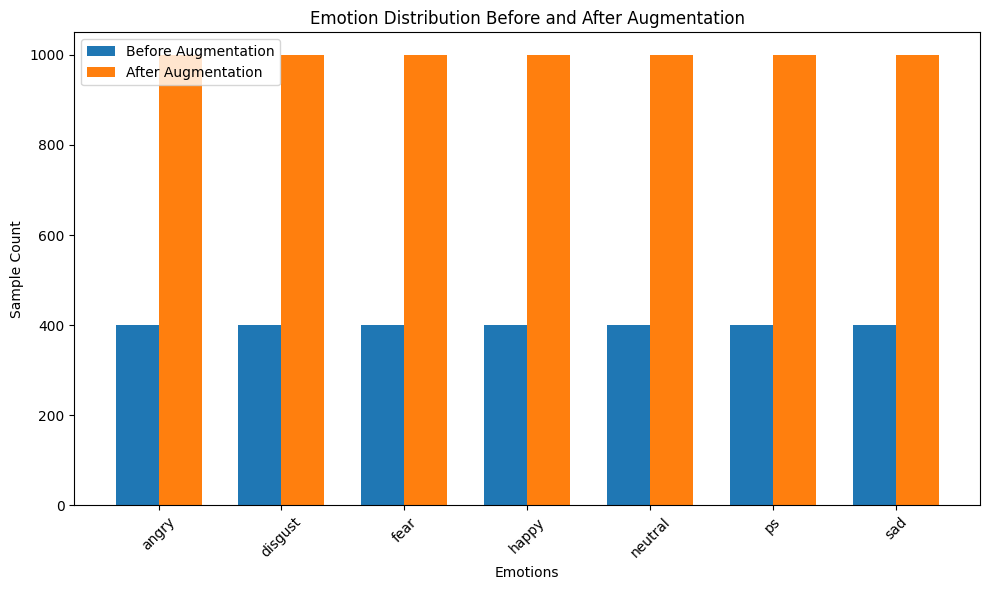

Epoch 1/50


c:\Users\DELL\anaconda3\envs\AI\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.2974 - loss: 1.6817 - val_accuracy: 0.5667 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.5707 - loss: 0.9820 - val_accuracy: 0.6105 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.6541 - loss: 0.7634 - val_accuracy: 0.6476 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.6585 - loss: 0.7325 - val_accuracy: 0.7971 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.7863 - loss: 0.5073 - val_accuracy: 0.8438 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.8069 - loss: 0.4184 - val_accuracy: 0.8210 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8333 - loss: 0.3789 - val_

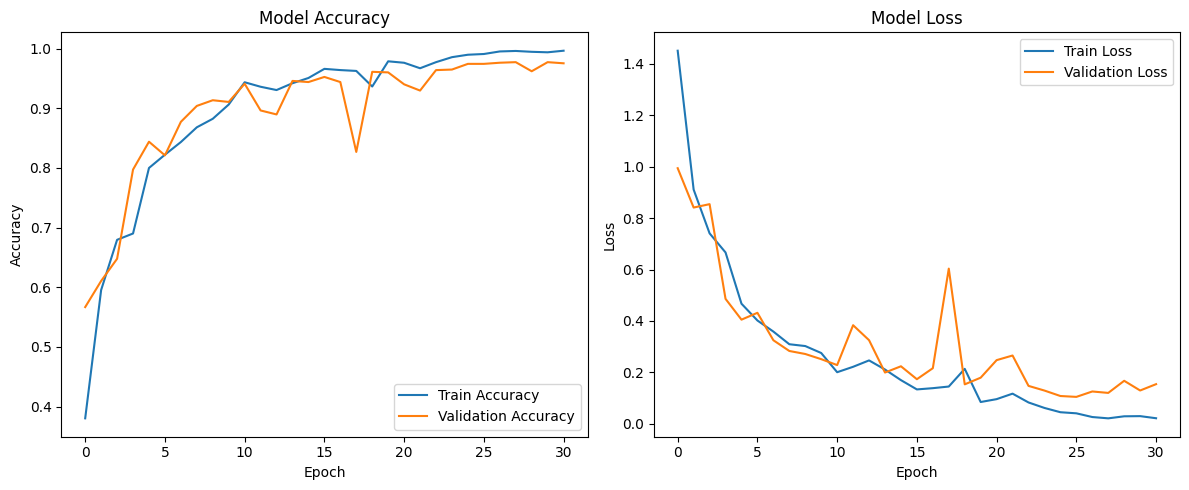

Training complete! Model and artifacts saved.


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain, Shift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import matplotlib.pyplot as plt

# Dataset path
data_path = r'C:/Users/DELL/Desktop/DSP assignment/Speech_recognition_TESS/TESS Toronto emotional speech set data'

def load_and_preprocess_data(data_path):
    paths, labels = [], []
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            if filename.endswith('.wav'):
                full_path = os.path.join(dirname, filename)
                try:
                    label = filename.split('_')[-1].split('.')[0].lower()
                    if 'pleasant' in label:
                        label = 'surprise'
                    paths.append(full_path)
                    labels.append(label)
                except IndexError:
                    print(f"Skipping file {filename} due to incorrect format.")
    
    if not labels:
        raise ValueError("No labels found. Check your data path and filename structure.")
    
    return pd.DataFrame({'speech': paths, 'label': labels})

def augment_audio():
    return Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
        Shift(min_shift=-0.5, max_shift=0.5, p=0.5)
    ])

def process_audio(file_path, augment=True, max_len=130):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    if augment:
        y = augment_audio()(samples=y, sample_rate=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T

def create_dataset(df, samples_per_class=1000):
    X_aug, y_aug = [], []
    for label in df['label'].unique():
        class_samples = df[df['label'] == label]
        count = len(class_samples)
        for i in range(samples_per_class):
            path = class_samples['speech'].iloc[i % count]
            aug = i >= count
            mfcc = process_audio(path, augment=aug)
            X_aug.append(mfcc)
            y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

def build_model(input_shape, num_classes):
    model = Sequential([
        LSTM(256, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # Load and preprocess data
    df = load_and_preprocess_data(data_path)
    print("Label distribution before augmentation:")
    before_counts = df['label'].value_counts()
    print(before_counts)
    
    # Create augmented dataset
    X, y = create_dataset(df)
    
    # After augmentation label distribution
    after_counts = pd.Series(y).value_counts().sort_index()
    
    # Plotting bar chart before and after augmentation
    labels = sorted(before_counts.index.union(after_counts.index))
    before_values = [before_counts.get(label, 0) for label in labels]
    after_values = [after_counts.get(label, 0) for label in labels]
    
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, before_values, width, label='Before Augmentation')
    plt.bar(x + width/2, after_values, width, label='After Augmentation')
    plt.xlabel('Emotions')
    plt.ylabel('Sample Count')
    plt.title('Emotion Distribution Before and After Augmentation')
    plt.xticks(ticks=x, labels=labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('augmentation_distribution.png')
    plt.show()
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    # Prepare data for LSTM
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # (samples, timesteps, features)
    
    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, stratify=y_categorical)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
    
    # Build and train model
    model = build_model((X.shape[1], X.shape[2]), len(label_encoder.classes_))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=callbacks
    )
    
    # Save model and artifacts
    model.save('emotion_detection_model.keras')
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    np.savez('test_data.npz', X_test=X_test, y_test=y_test)
    
    # Plot training history
    plot_training_history(history)
    
    print("Training complete! Model and artifacts saved.")


if __name__ == "__main__":
    main()

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.97      0.98       150
     disgust       0.97      0.98      0.98       150
        fear       1.00      0.99      0.99       150
       happy       0.92      0.97      0.95       150
     neutral       0.99      0.99      0.99       150
          ps       0.97      0.93      0.95       150
         sad       0.98      0.99      0.98       150

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



<Figure size 1200x600 with 0 Axes>

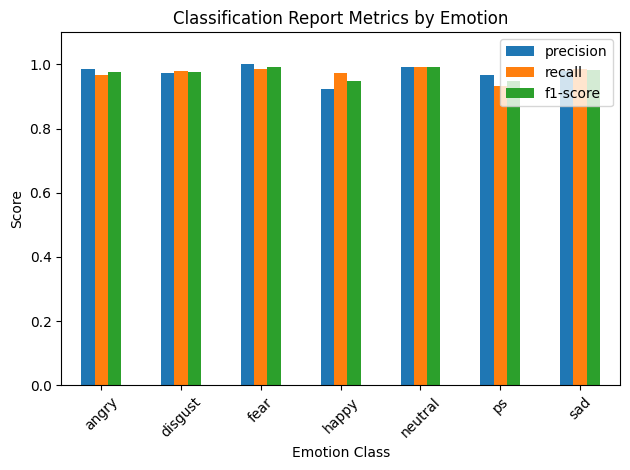

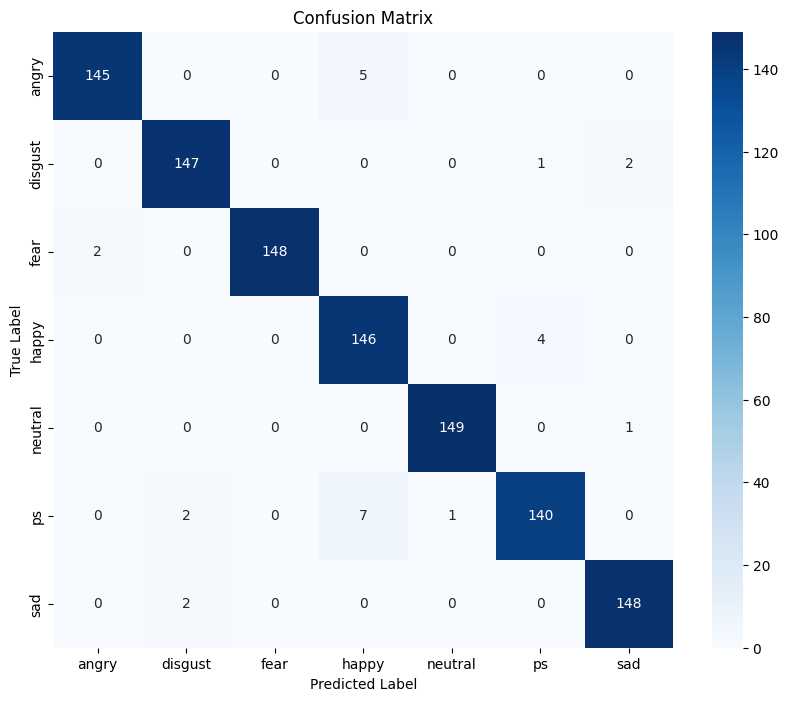

Recording for 3 seconds...

Prediction Results:
- Predicted Emotion: Sad
- Confidence: 61.10%

Top Predictions:
- sad: 61.10%
- disgust: 23.63%
- neutral: 3.46%
Recording for 3 seconds...

Prediction Results:
- Predicted Emotion: Sad
- Confidence: 39.57%

Top Predictions:
- sad: 39.57%
- disgust: 33.13%
- happy: 5.83%


In [ ]:
import numpy as np
import librosa
import sounddevice as sd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Constants
MAX_LEN = 130

def load_test_data():
    data = np.load('test_data.npz')
    return data['X_test'], data['y_test']

def load_model_and_encoder():
    model = load_model('emotion_detection_model.keras')
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    return model, label_encoder

def evaluate_model(model, label_encoder, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report as dict
    report_dict = classification_report(
        y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    report_df = pd.DataFrame(report_dict).T.drop(['accuracy', 'macro avg', 'weighted avg'])

    # Print the classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Bar chart of precision, recall, and F1-score
    plt.figure(figsize=(12, 6))
    report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
    plt.title('Classification Report Metrics by Emotion')
    plt.xlabel('Emotion Class')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('classification_report_bar_chart.png')
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

def extract_mfcc_realtime(data, sr):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < MAX_LEN:
        pad_width = MAX_LEN - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_LEN]
    return mfcc.T

def real_time_testing():
    model, label_encoder = load_model_and_encoder()
    
    while True:
        input_text = input("\n🎤 Press ENTER to record (or type 'exit' to quit): ")
        if input_text.lower() == 'exit':
            print("Exiting real-time testing.")
            break

        print("Recording for 3 seconds...")
        sr = 22050
        duration = 3
        audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
        sd.wait()
        audio = audio.flatten()

        mfcc = extract_mfcc_realtime(audio, sr)
        mfcc = mfcc[np.newaxis, ...]

        prediction = model.predict(mfcc, verbose=0)
        predicted_idx = np.argmax(prediction)
        predicted_label = label_encoder.inverse_transform([predicted_idx])[0]
        confidence = prediction[0][predicted_idx]
        
        print("\nPrediction Results:")
        print(f"- Predicted Emotion: {predicted_label.capitalize()}")
        print(f"- Confidence: {confidence:.2%}")
        
        print("\nTop Predictions:")
        top_indices = np.argsort(prediction[0])[::-1][:3]
        for idx in top_indices:
            print(f"- {label_encoder.classes_[idx]}: {prediction[0][idx]:.2%}")

def main():
    model, label_encoder = load_model_and_encoder()
    X_test, y_test = load_test_data()

    evaluate_model(model, label_encoder, X_test, y_test)
    real_time_testing()

if __name__ == "__main__":
    main()
